# Second-hand car market in Spain

## Problem and data

Our boss has asked us to conduct a study of the second-hand vehicle market in Spain, as he is considering expanding the company's activities (selling new cars) with a second-hand car dealership. We have a database with 50,000 records and we need to identify which variables influence the price of vehicles, as well as create a model that predicts the price of a second-hand car based on its characteristics.

The available data includes:

* url: link to the original ad
* company: link to the original ad home
* make: brand
* model
* version
* price
* price_financed
* fuel
* year: year of production
* kms
* power
* doors: number of doors
* shift
* color
* photos: number of pictures in the ad
* is_professional: whereas the seller is professional or a particular
* dealer: identification of the seller
* province
* country
* publish_date: date of the ad publication
* insert_date: dato of the data extraction

## Imports

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor

## Data loading and initial overview.

We have a total of **50,000 records** with **21 columns of information**.

The presumably numeric variables (price, price_financed, year, kms, power, doors, photos) appear to be numeric (integer or decimal). There are two variables containing dates (publish_date, insert_date) but they are typed as objects (will need conversion). "is_professional" is a boolean variable, and the rest are object type variables containing text.

Regarding **missing values**, there are very few in the dataset. "price_financed" has the highest number of missing values (more than 50%), but it's a variable we won't use in the model. "Power" has 8.528 missing values, followed distantly by: color (594), shift (111), fuel (46), province (6), model (5), make (2), and year (2).

**Numeric variables** are on widely **disparate scales**. Price and kms exhibit highly dispersed values (large standard deviation). In both cases, the values in the last quartile are significantly higher than the rest of the data, indicating **outliers**, leading to **long-tail distributions**.

In [2]:
# Cargamos el csv y creamos un df con sus datos
df=pd.read_csv("./data/coches-de-segunda-mano-sample.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              50000 non-null  object 
 1   company          50000 non-null  object 
 2   make             49998 non-null  object 
 3   model            49995 non-null  object 
 4   version          50000 non-null  object 
 5   price            50000 non-null  int64  
 6   price_financed   23563 non-null  float64
 7   fuel             49954 non-null  object 
 8   year             49998 non-null  float64
 9   kms              50000 non-null  int64  
 10  power            41472 non-null  float64
 11  doors            50000 non-null  int64  
 12  shift            49889 non-null  object 
 13  color            49406 non-null  object 
 14  photos           50000 non-null  int64  
 15  is_professional  50000 non-null  bool   
 16  dealer           50000 non-null  object 
 17  province    

In [4]:
df.describe()

,price,price_financed,year,kms,power,doors,photos
count,50000.000000,23563.000000,49998.000000,5.000000e+04,41472.000000,50000.000000,50000.000000
mean,15166.270260,18480.029283,2012.311032,1.163591e+05,146.396388,4.505380,16.199120
std,16485.669747,13389.800738,6.677760,1.072921e+05,71.283964,0.868001,12.422882
min,300.000000,700.000000,1970.000000,0.000000e+00,29.000000,2.000000,0.000000
25%,5500.000000,10790.000000,2007.000000,3.830000e+04,109.000000,4.000000,7.000000
50%,11750.000000,15500.000000,2015.000000,9.999900e+04,130.000000,5.000000,13.000000
75%,19800.000000,21995.000000,2018.000000,1.749000e+05,163.000000,5.000000,23.000000
max,549900.000000,428999.000000,2021.000000,5.000000e+06,800.000000,5.000000,54.000000


In [5]:
# The original dataset is copied under the name of df_copy.
df_copy=df.copy()

In [6]:
df.head(3)

,url,company,make,model,version,price,price_financed,fuel,year,kms,...,doors,shift,color,photos,is_professional,dealer,province,country,publish_date,insert_date
0,e158ae0ca53119ca199c28c36b5c2fcd,9881bcdd5a0ad4733037b3fb25e69c3a,SEAT,Toledo,SEAT Toledo 4p.,950,NaN,Diésel,2000.0,227000,...,4,Manual,Verde,5,False,0f4bb8455d27349b8273109b66a847f3,Navarra,Spain,2020-12-18 10:47:13,2021-01-15 00:00:00
1,ff267ebb7e700246f47f84f3db660b4b,9881bcdd5a0ad4733037b3fb25e69c3a,CITROEN,C1,CITROEN C1 PureTech 60KW 82CV Feel 5p.,6200,NaN,Gasolina,2017.0,50071,...,5,Manual,Blanco,6,True,Autos Raymara,Tenerife,Spain,2021-01-02 11:25:40,2021-01-15 00:00:00
2,de4b02db28ea7786c622b969be10c7c7,9881bcdd5a0ad4733037b3fb25e69c3a,FORD,Transit Connect,FORD Transit Connect Van 1.5 TDCi 100cv Ambien...,7851,7024.0,Diésel,2016.0,103000,...,4,Manual,Blanco,10,True,Auto 96,Barcelona,Spain,2020-12-16 10:51:45,2021-01-15 00:00:00


After reviewing the data, we identified **some variables** that we can **deleted** directly:

* url and company: they are links to the data source
* price_financed
* version: contains information already present in other variables
* dealer: individual identification of each seller
* country: since it is a dataset from Spain, this variable does not add value
* publish_date and insert_date: dates related to data publication and extraction

In [7]:
df.drop(columns=["url","company","price_financed","version","dealer","country","publish_date","insert_date"],axis=1,inplace=True)

In [8]:
df.head(3)

,make,model,price,fuel,year,kms,power,doors,shift,color,photos,is_professional,province
0,SEAT,Toledo,950,Diésel,2000.0,227000,NaN,4,Manual,Verde,5,False,Navarra
1,CITROEN,C1,6200,Gasolina,2017.0,50071,82.0,5,Manual,Blanco,6,True,Tenerife
2,FORD,Transit Connect,7851,Diésel,2016.0,103000,100.0,4,Manual,Blanco,10,True,Barcelona


**Power** and **year** are numerical variables with **missing values**. These missing values will be imputed using the **KNN** system, which estimates the missing values based on similar neighboring data points.

In [9]:
columns_to_impute = ["power","year"]
imputer = KNNImputer(n_neighbors=3)
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

Records whose **prices** are **higher than 100.000€** are deleted since they are considered **outliers**.

In [10]:
df=df[df["price"] <= 100000]

In [11]:
df["price"].describe()

count     49805.000000
mean      14580.118221
std       12806.163718
min         300.000000
25%        5499.000000
50%       11600.000000
75%       19545.000000
max      100000.000000
Name: price, dtype: float64

Some of the categorical columns have a **few missing** values, which will be **removed** from the dataset. 

In [12]:
df.dropna(inplace=True)

After that we have a total of **49.004** records and no missing information.

In [13]:
# Check there are no missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49044 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   make             49044 non-null  object 
 1   model            49044 non-null  object 
 2   price            49044 non-null  int64  
 3   fuel             49044 non-null  object 
 4   year             49044 non-null  float64
 5   kms              49044 non-null  int64  
 6   power            49044 non-null  float64
 7   doors            49044 non-null  int64  
 8   shift            49044 non-null  object 
 9   color            49044 non-null  object 
 10  photos           49044 non-null  int64  
 11  is_professional  49044 non-null  bool   
 12  province         49044 non-null  object 
dtypes: bool(1), float64(2), int64(4), object(6)
memory usage: 4.9+ MB


## Train-Test Split

The process of training and evaluating a model requires a careful division of the dataset into two main parts: the training set and the testing set.

* **Training Set**: The training set is the portion of the dataset used to train the machine learning model. It is akin to the "study material" for the model, where it learns patterns and relationships between input features and the target variable. It is made by 80% of the dataset: **39.235 records**.

* **Testing Set**: The testing set, on the other hand, is a completely separate portion of the dataset that the model has not seen during training. It serves as an unseen evaluation set to assess how well the trained model generalizes to new, unseen data. It is made by 20% of the dataset: **9.809 records**.

In [14]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [15]:
print(f"Train set: {train_set.shape}.")
print(f"Test set: {test_set.shape}.")

Train set: (39235, 13).
Test set: (9809, 13).


## EDA

Exploratory Data Analysis (EDA) is a crucial initial step in any machine learning project. It involves examining and understanding the dataset to gain insights that can inform the subsequent steps of the project. In this section, we delve into the dataset to discover its underlying patterns, distributions, and relationships. 

### Univarite analysis

#### Target

As said in the introduction, the target of our model is the **price** of the vehicle.
75% of the traininig set has a price between 300€ and 19.900€. However, the highest price in the training set is 429.999€ meaning there are a few **outliers** giving the variable a **long-tail distribution**.

In [16]:
target=	"price"

In [17]:
train_set[target].describe()

count     39235.000000
mean      14698.692265
std       12820.603645
min         300.000000
25%        5500.000000
50%       11900.000000
75%       19850.000000
max      100000.000000
Name: price, dtype: float64

(2,)


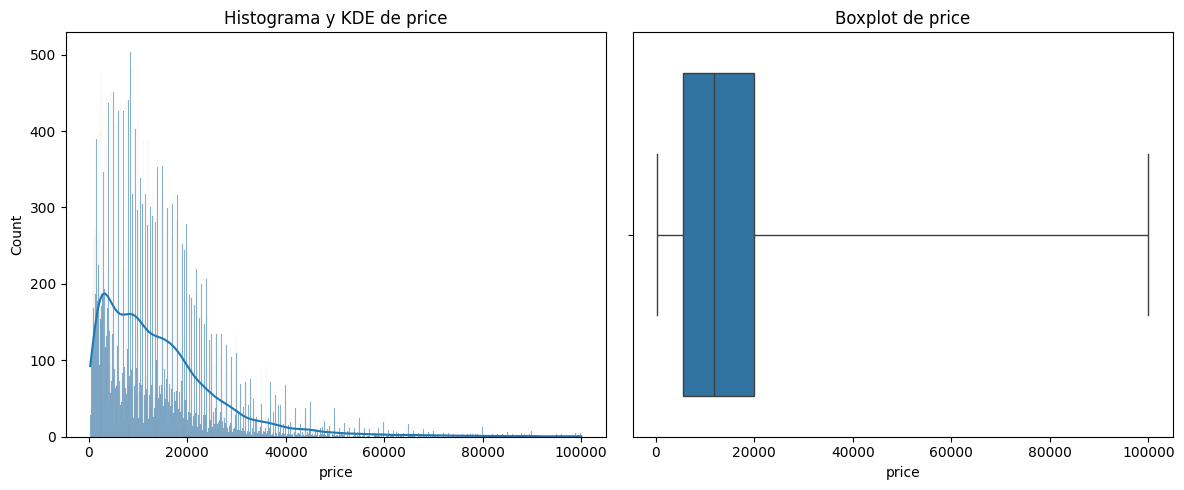

In [18]:
bt.plot_combined_graphs(train_set,[target],whisker_width=400, bins = 1000)

#### Análisis univariante

#### Make and brand

The "make" variable pertains to the brand of the vehicle, encompassing 72 unique values with a cardinality of 0.18%. The top 20 brands represent 90.71% of the dataset.

To simplify this variable, we have created a **new column** called "**brand**". The top 20 brands remain unchanged, while the other brands are categorized based on their average price into four categories:

* low_cost: Brands with a mean price below 6,000€
* medium_low_cost: Brands with a mean price between 6,000€ and 20,000€
* medium_high_cost: Brands with a mean price between 20,000€ and 50,000€
* high_cost: Brands with a mean price over 50,000€

In [19]:
unique_make=train_set["make"].nunique()
print(f"Unique values: {unique_make}")
card_make=train_set["make"].nunique()/len(train_set["make"])
print(f"Cardinality: {round(card_make,4)*100}%")
top_make=train_set["make"].value_counts(normalize=True).nlargest(20).sum()
print(f"Top 20 brands: {round(top_make,4)*100}%")

Unique values: 72
Cardinality: 0.18%
Top 20 brands: 90.71000000000001%


In [20]:
# Top 20 brands.
top20=train_set["make"].value_counts(normalize=True).nlargest(20).index.to_list()

In [21]:
def assign_brand(df):

# Input: DataFrame with a "make" column.
# Functionality: looks up each brand in the top20 list to find its name,
#                if it is not found,it assigns a corresponding category based on its mean price 
#                creates a new "brand" column with the assigned brand or category, 
#                and then removes the original "make" column. 
# Output: DataFrame with an additional "brand" column and no "make" column.

    cat_list=[]
    for brand in df["make"]:
        if brand in top20:
            cat=brand
        else:
            meanp = df.loc[df["make"] == brand, "price"].mean()
            if meanp<6000:
                cat="low_cost"
            elif meanp <20000:
                cat="medium_low_cost"
            elif meanp <50000:
                cat="medium_high_cost"
            else:
                cat="high_cost" 
        cat_list.append(cat)  
    
    df["brand"]=cat_list    

        
    # Delete the original column.
    df.drop("make",axis=1,inplace=True)  

In [22]:
assign_brand(train_set)

**Volkswagen, BMW and Mercedes-Benz** are the three best-selling brands in the second-hand market. The **least sold brands** are **low cost** and **high cost** brands . Among the unidentified brands, brands with an average price between 6.000 and 20.000€ are significantly the most numerous.

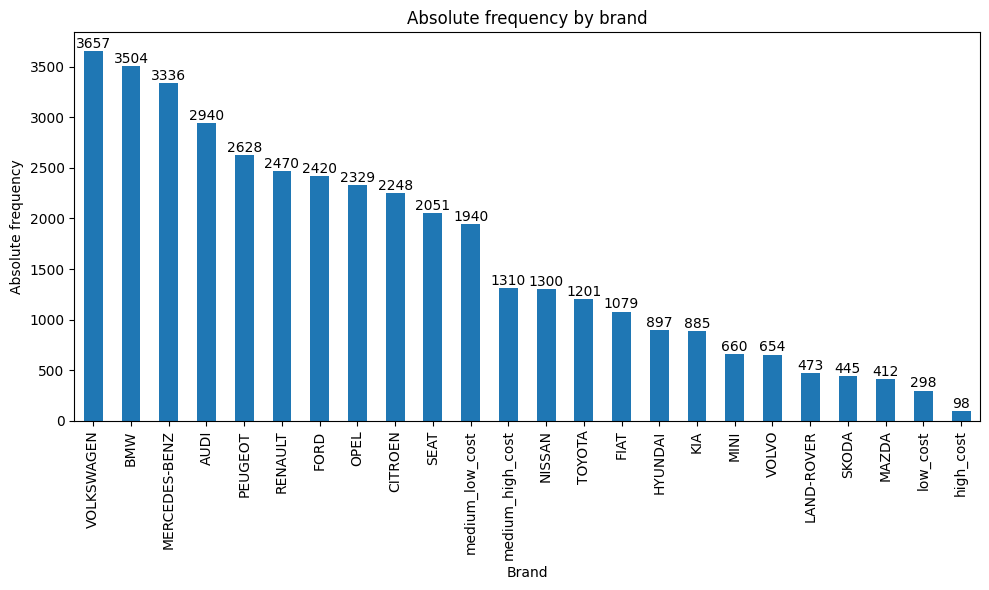

In [23]:
# Create the figure
brand_counts = train_set["brand"].value_counts()
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='bar')

# Aggregate the values for each brand
for i, value in enumerate(brand_counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Tags and tittles
plt.xlabel('Brand')
plt.ylabel('Absolute frequency')
plt.title('Absolute frequency by brand')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the figure
plt.show()

In [24]:
train_set["brand"].value_counts(normalize=True)

brand
VOLKSWAGEN          0.093208
BMW                 0.089308
MERCEDES-BENZ       0.085026
AUDI                0.074933
PEUGEOT             0.066981
RENAULT             0.062954
FORD                0.061680
OPEL                0.059360
CITROEN             0.057296
SEAT                0.052275
medium_low_cost     0.049446
medium_high_cost    0.033389
NISSAN              0.033134
TOYOTA              0.030610
FIAT                0.027501
HYUNDAI             0.022862
KIA                 0.022556
MINI                0.016822
VOLVO               0.016669
LAND-ROVER          0.012056
SKODA               0.011342
MAZDA               0.010501
low_cost            0.007595
high_cost           0.002498
Name: proportion, dtype: float64

In [25]:
for var in train_set["brand"].unique():
    mean_price = round(train_set[train_set["brand"] == var]["price"].mean(),2)
    print(f"{var}: {mean_price}€")

VOLKSWAGEN: 13154.27€
SEAT: 10198.57€
MERCEDES-BENZ: 23243.87€
CITROEN: 9302.81€
OPEL: 9619.35€
FIAT: 8986.33€
medium_high_cost: 30403.4€
TOYOTA: 13065.2€
PEUGEOT: 11448.25€
VOLVO: 21013.92€
FORD: 10255.98€
BMW: 18771.14€
medium_low_cost: 11683.77€
low_cost: 3809.86€
SKODA: 13261.95€
RENAULT: 9186.11€
AUDI: 18779.92€
NISSAN: 13847.81€
HYUNDAI: 13192.95€
MAZDA: 14041.34€
LAND-ROVER: 32678.28€
KIA: 14831.76€
MINI: 14929.76€
high_cost: 56331.22€


#### Model and segment

The "model" has a cardinality of 2.3% with a total of 893 unique values. The top 300 models represent 89.53% of the dataset.

To simplify this variable, we have created a **new column** called "**segment**" where the top 300 models are categorized in its segment. The other 619 models' segment are categorized as Unknown. The segments are:

* Segment A: small cars
* Segment B: small cars
* Segment C: mid-size cars
* Segment D: large cars
* Segment E: high-end cars
* SegmentF: luxury cars

In [26]:
unique_model=train_set["model"].nunique()
print(f"Unique values: {unique_model}")
card_model=train_set["model"].nunique()/len(train_set["model"])
print(f"Cardinality: {round(card_model,4)*100}%")
top_model=train_set["model"].value_counts(normalize=True).nlargest(300).sum()
print(f"Top 300 models: {round(top_model,4)*100}%")

Unique values: 893
Cardinality: 2.2800000000000002%
Top 300 models: 89.53%


In [27]:
# We look for the top 300 models and create a dictionary with their segment.
lista_modelos = train_set["model"].value_counts(normalize=True).nlargest(300).index.to_list()

In [28]:
# Dictionary.
segments_dict = {
    'Golf': 'C',
    'Serie 3': 'D',
    'A4': 'D',
    'A3': 'C',
    'Mégane': 'C',
    'Clase C': 'D',
    'Focus': 'C',
    'Astra': 'C',
    'Ibiza': 'B',
    'León': 'C',
    'Serie 1': 'C',
    'Passat': 'D',
    'QASHQAI': 'C',
    'Corsa': 'B',
    'MINI': 'B',
    'Clio': 'B',
    'Serie 5': 'E',
    '308': 'C',
    'Polo': 'B',
    'Clase A': 'C',
    'Clase E': 'E',
    'Fiesta': 'B',
    'C3': 'B',
    'Insignia': 'D',
    '500': 'A',
    'A6': 'E',
    'Mondeo': 'D',
    'Auris': 'C',
    'C4': 'C',
    'Touran': 'D',
    '3008': 'C',
    'Berlingo': 'D',
    'A5': 'D',
    'X1': 'D',
    'Scénic': 'C',
    '208': 'B',
    'Tiguan': 'C',
    '2008': 'B',
    'Kuga': 'C',
    'Serie 4': 'D',
    'JUKE': 'B',
    'X5': 'E',
    'Clase B': 'B',
    '508': 'D',
    'X3': 'E',
    'Sportage': 'C',
    'Arona': 'B',
    'Octavia': 'D',
    'Yaris': 'B',
    '5008': 'D',
    "Q5": "D",
    "A1": "B",
    "TUCSON": "C",
    "Partner": "F",
    "Laguna": "D",
    "Clase GLA": "C",
    "C-Max": "C",
    "Q3": "C",
    "Captur": "B",
    "Grand Scénic": "C",
    "Countryman": "C",
    "i30": "C",
    "C4 Cactus": "B",
    "Grand C4 Picasso": "C",
    "Vito": "F",
    "Zafira": "F",
    "207": "B",
    "Range Rover Evoque": "D",
    "C5": "D",
    "Clase CLA": "D",
    "X-TRAIL": "C",
    "C4 Picasso": "C",
    "Rav4": "C",
    "XC60": "D",
    "C-HR": "C",
    "Tipo": "B",
    "Clase GLC": "D",
    "Caddy": "F",
    "Civic": "B",
    "Micra": "B",
    "206": "B",
    "ceed": "B",
    "Cayenne": "F",
    "Ateca": "C",
    "307": "B",
    "407": "D",
    "Scirocco": "D",
    "fortwo": "A",
    "Xsara Picasso": "C",
    "Fabia": "B",
    "911": "F",
    "Clase S": "F",
    "Q7": "F",
    "Kadjar": "C",
    "Range Rover Sport": "D",
    "CR-V": "C",
    "Corolla": "B",
    "C3 Aircross": "B",
    "Clase M": "D",
    "Vectra": "D",
    "Avensis": "D",
    "XC90": "F",
    "Panda": "A",
    "i20": "B",
    "EcoSport": "B",
    "Sandero": "B",
    "X6": "F",
    "Clase V": "F",
    "Transporter": "F",
    "Mokka X": "C",
    "C-Elysée": "B",
    "Serie 7": "F",
    "Aygo": "A",
    "Xsara": "B",
    "Carens": "C",
    "Clase CLK": "D",
    "Transit": "F",
    "CX-5": "C",
    "S60": "D",
    "Kona": "B",
    "Touareg": "F",
    "Serie 2 Gran Tourer": "B",
    "Serie 2": "B",
    "TT": "D",
    "Toledo": "C",
    "Superb": "D",
    "Panamera": "F",
    "Punto": "B",
    "S-MAX": "D",
    "Espace": "D",
    "Alhambra": "D",
    "Mazda3": "B",
    "Stonic": "B",
    "Vivaro": "F",
    "i40": "C",
    "Jumper": "F",
    "Grandland X": "C",
    "Mazda6": "D",
    "307 SW": "B",
    "Compass": "C",
    "Serie 2 Active Tourer": "B",
    "Verso": "C",
    "Kangoo Combi": "C",
    "Rodius": "F",
    "X4": "F",
    "F-Pace": "F",
    "ALTEA": "C",
    "Trafic": "F",
    "Multivan": "F",
    "Combo": "F",
    "V40": "C",
    "Talisman": "D",
    "Córdoba": "B",
    "Boxer": "F",
    "Q2": "C",
    "Crossland X": "B",
    "500": "A",
    "LEAF": "B",
    "Clase CLS": "E",
    "V60": "D",
    "NX": "D",
    "Renegade": "B",
    "Altea XL": "C",
    "Sprinter": "F",
    "Accord": "D",
    "Picanto": "A",
    "Zoe": "B",
    "Clase SLK": "E",
    "T-Roc": "C",
    "GLA": "C",
    "500X": "B",
    "ix35": "C",
    "Outlander": "C",
    "9-3": "D",
    "Caravelle": "F",
    "Ducato": "F",
    "C5 Aircross": "C",
    "Meriva": "B",
    "Giulietta": "C",
    "i10": "A",
    "XCeed": "B",
    "Rio": "B",
    "Kangoo Furgón": "C",
    "Jumpy": "F",
    "Swift": "B",
    "i3": "B",
    "Serie 6": "E",
    "Macan": "E",
    "Expert": "F",
    "ASX": "C",
    "forfour": "A",
    "Vitara": "C",
    "C1": "A",
    "IONIQ": "B",
    "Niro": "C",
    "Master": "F",
    "XF": "E",
    "Discovery Sport": "E",
    "406": "D",
    "Doblò": "F",
    'Duster': 'C',
    '220': 'D',
    'A8': 'D',
    'Puma': 'E',
    'Tarraco': 'F',
    'Sharan': 'F',
    'Saxo': 'A',
    'Santa Fe': 'E',
    'S40': 'D',
    'Grand Cherokee': 'E',
    'Almera': 'B',
    'Transit Connect': 'B',
    'Aveo': 'B',
    'C2': 'B',
    'KA': 'B',
    'Sorento': 'E',
    'Corolla Verso': 'C',
    '500L': 'F',
    'Kangoo': 'F',
    'Mokka': 'B',
    'Grand C-Max': 'B',
    '500C': 'B',
    'Adam': 'B',
    'Viano': 'D',
    'Exeo': 'D',
    'Crafter': 'F',
    'Giulia': 'E',
    'Beetle': 'E',
    'CLUBMAN': 'D',
    'XE': 'D',
    'GLC Coupé': 'B',
    'Ka+': 'C',
    'CC': 'D',
    'Daily': 'E',
    'Carnival': 'F',
    'Compact': 'F',
    'Defender': 'F',
    'A7': 'F',
    'Range Rover Velar': 'F',
    'Freelander': 'F',
    'e-208': 'C',
    'Fusion': 'D',
    'IS': 'D',
    'CLA': 'F',
    'Zafira Tourer': 'D',
    'Galaxy': 'F',
    'Stilo': 'C',
    'Clase GLE': 'F',
    '147': 'D',
    'Montero': 'F',
    'Rifter': 'F',
    'Citan': 'F',
    'Doblò Cargo': 'F',
    'Clase GLE Coupé': 'E',
    'Cruze': 'D',
    'Logan': 'B',
    'T-Cross': 'C',
    'CX-3': 'C',
    'Transit Courier': 'F',
    'Range Rover': 'E',
    'Fiorino': 'B',
    'Korando': 'E',
    'Passat CC': 'D',
    'XC40': 'D',
    'Twingo': 'A',
    'Golf Sportsvan': 'C',
    'Dokker': 'B',
    'Stelvio': 'E',
    'Lodgy': 'D',
    'Mazda2': 'B',
    'NOTE': 'B',
    'Captiva': 'E',
    'S3': 'D',
    'Transit Custom': 'F',
    'New Beetle': 'C',
    'Z4': 'E',
    'Antara': 'E',
    'California': 'F',
    'Wrangler': 'F',
    '407 SW': 'D',
    'Discovery': 'E',
    'Land Cruiser': 'E',
    'Primera': 'D',
    'L200': 'F',
    'Pro Ceed': 'C',
    'Bravo': 'C',
    'Prius': 'C',
    'X2': 'D',
    '807': 'F',
    'A4 Allroad Quattro': 'D',
    'PULSAR': 'C',
    '108': 'A',
    'Coupé': 'D',
    'V50': 'D',
    'Clase R': 'E',
    'Grand Voyager': 'F',
    'Scudo': 'F',
    '306': 'C',
    'CT': 'D',
    'Golf Plus': 'C'
}


In [29]:
def assign_segment(df):

# Input: DataFrame with a "model" column.
# Functionality: looks up each car model in a segments_dict to find its corresponding segment, 
#                creates a new "segment" column with the assigned segments, 
#                and then removes the original "model" column. 
# Output: DataFrame with an additional "segment" column and no "model" column.

    segment=[]
    for car in df["model"]:
        seg="Unknown"
        for car_seg,seg_dict in segments_dict.items():
            if car==car_seg:
                seg=seg_dict
                break
        segment.append(seg)
    df["segment"]=segment
    
    df.drop("model",axis=1,inplace=True)  
    

In [30]:
assign_segment(train_set)

The highest-selling models belong to the **C segment**, comprising approximately 30% of the records with a mean price of 13.543€. Segment D as the second most popular, shortly followed by Segment B. Segment A cars are the least sold, accounting for only 2% of the records.

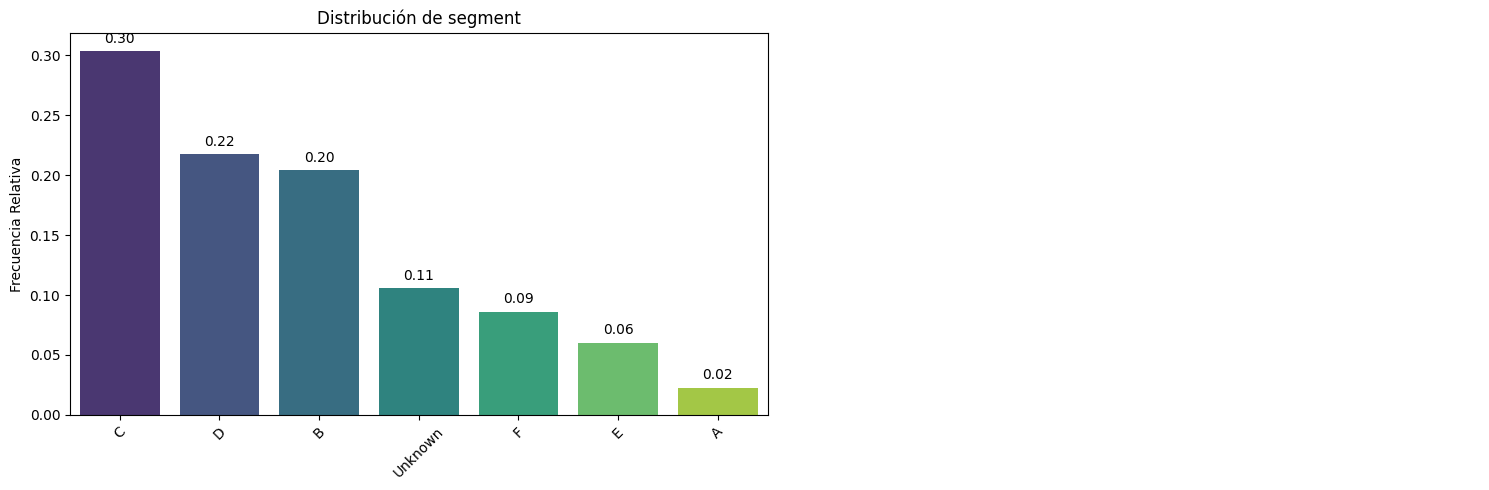

In [31]:
bt.pinta_distribucion_categoricas(train_set, ["segment"], relativa= True, mostrar_valores= True)

In [32]:
for var in train_set["segment"].unique():
    mean_price = round(train_set[train_set["segment"] == var]["price"].mean(),2)
    print(f"Mean price for segment {var}: {mean_price}€")

Mean price for segment C: 13550.33€
Mean price for segment F: 20913.33€
Mean price for segment D: 15375.91€
Mean price for segment Unknown: 16812.57€
Mean price for segment E: 20216.01€
Mean price for segment B: 10945.69€
Mean price for segment A: 9202.94€


#### Fuel

There are **7 different types** of fuel. **Diesel** is the most common, used by 62% of the vehicles. **Gasolina** is the second most frequent fuel, accounting for approximately 33%. However, both have much **cheaper** prices than electric and hibrib vehicles.

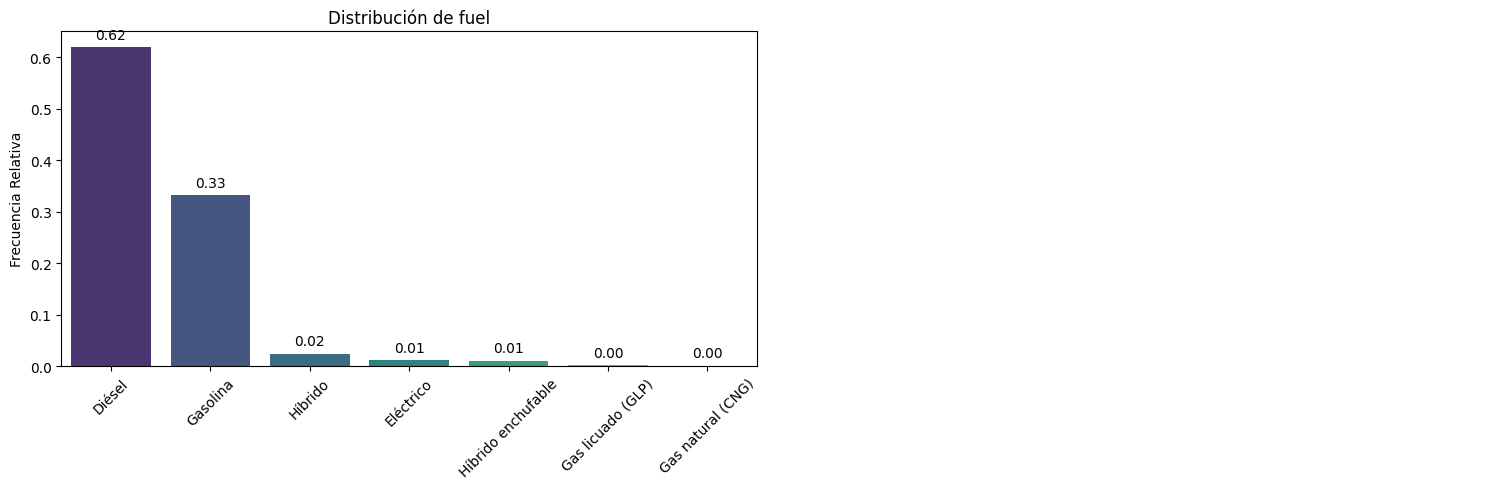

In [33]:
bt.pinta_distribucion_categoricas(train_set, ["fuel"], relativa= True, mostrar_valores= True)

In [34]:
for var in train_set["fuel"].unique():
    mean_price = round(train_set[train_set["fuel"] == var]["price"].mean(),2)
    print(f"Mean price for {var}: {mean_price}€")

Mean price for Gasolina: 14460.02€
Mean price for Diésel: 13904.89€
Mean price for Híbrido: 22574.24€
Mean price for Híbrido enchufable: 38078.19€
Mean price for Eléctrico: 28044.35€
Mean price for Gas licuado (GLP): 9400.69€
Mean price for Gas natural (CNG): 14310.64€


#### Year, publish date, insert date and age

The variable year refers to the year of manufacture of the vehicle. Given that the cardinality of this variable is 0.13%, we categorize the vehicle ages into four ranges under the variable "**age**":

* Almost new: less than 6 years old
* Medium age: 6 to 16 years old
* Old: 17 to 25 years old
* Historic: over 25 years old, 

Publish date and insert date are not necessary so they can be deleted.

In [35]:
unique_years=train_set["year"].nunique()
print(f"Unique values: {unique_years}")
card_years=train_set["year"].nunique()/len(train_set["year"])
print(f"Cardinality: {round(card_years,4)*100}%")

Unique values: 52
Cardinality: 0.13%


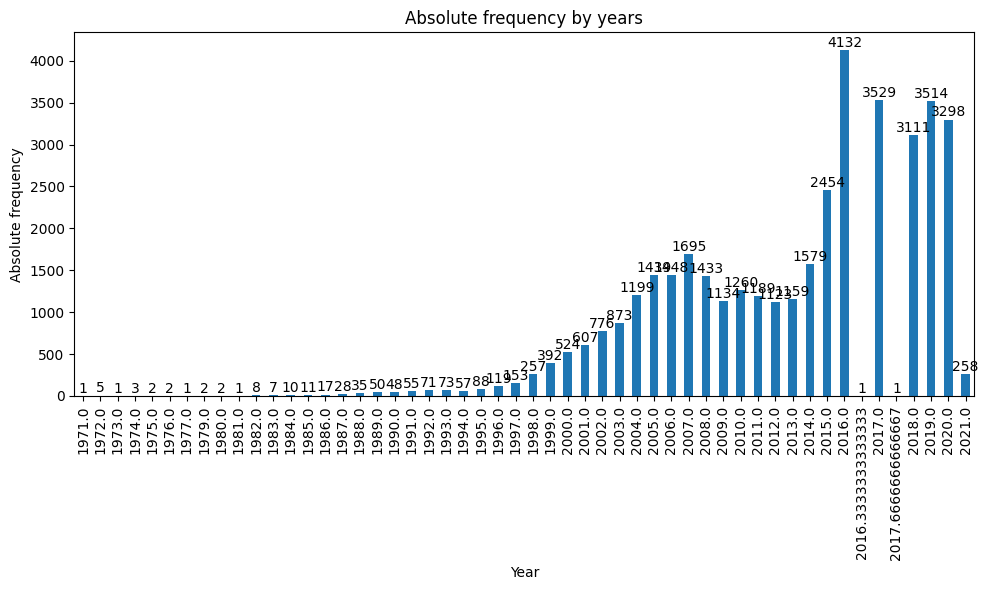

In [36]:
# We create a bar graph to visualize the distribution of vehicle ages across different ranges.

# Create the figure
years_counts = train_set["year"].value_counts().sort_index()
plt.figure(figsize=(10, 6))
years_counts.plot(kind='bar')

# Aggregate the values for each brand
for i, value in enumerate(years_counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Tags and tittles
plt.xlabel('Year')
plt.ylabel('Absolute frequency')
plt.title('Absolute frequency by years')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the figure
plt.show()

In [37]:
def assign_age(df):

# Input: DataFrame with a "year" column (representing the manufacturing year of cars).
# Functionality: assigns an "age" category to each car based on the year,
#                creates a new "age" column with the assigned age categories, 
#                and then removes the original "year" column. 
# Output: DataFrame with an additional "age" column.

    range_years=[]
    for year in df["year"]:
        value="Almost new"
        if year<2016:
            value="Old"
        if year<2006:
            value="Classic"
        range_years.append(value)
    df["age"]=range_years
    
    df.drop("year", axis=1, inplace=True)

In [38]:
assign_age(train_set)

**45%** of the records represent **almost new vehicles** (under 6 years old), 37% fall between 6 and 16 years old and 18% are classic cars (over 17 years old).

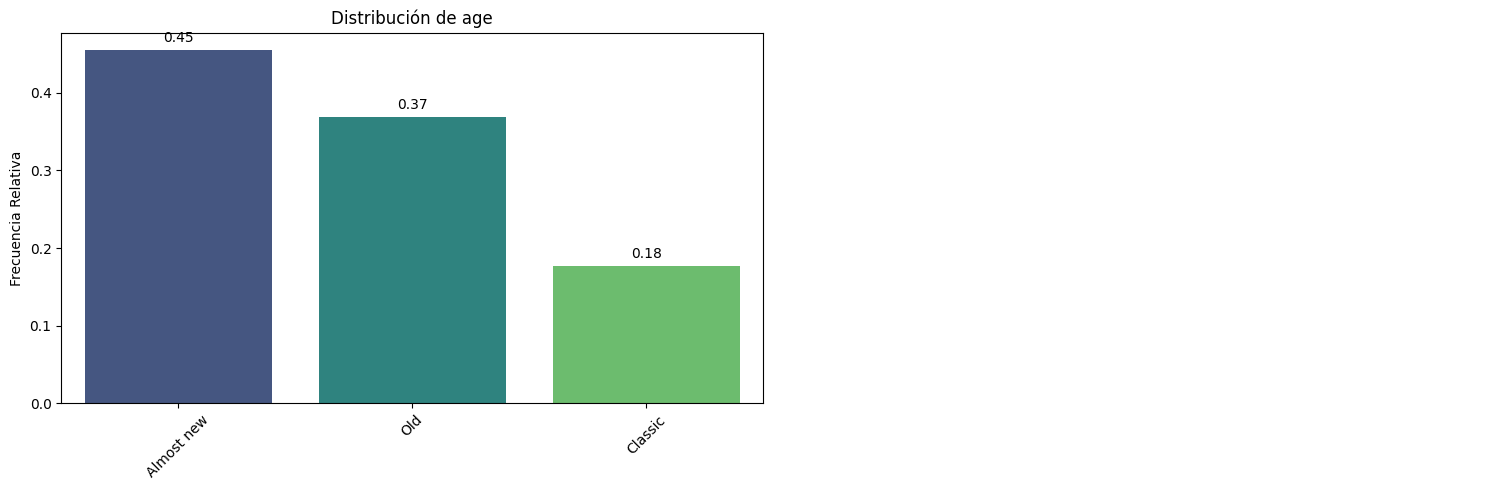

In [39]:
bt.pinta_distribucion_categoricas(train_set, ["age"], relativa= True, mostrar_valores= True)

In [40]:
for var in train_set["age"].unique():
    mean_price = round(train_set[train_set["age"] == var]["price"].mean(),2)
    print(f"Mean price for {var}: {mean_price}€")

Mean price for Almost new: 22120.77€
Mean price for Classic: 3783.58€
Mean price for Old: 10764.76€


#### Kms

50% of the vehicles have less than 100,000 km, and **75% of the vehicles**, have **under 175,000 km**. However, the vehicle with the highest mileage has 5 million kilometers. Considering how suspicious this data seems, we analyze the top 20 records with the most mileage and find that the top 14 have over 1 million kilometers. Cars with more than 500.000Kms are deleted since they are considered as wrong data.

In [41]:
train_set["kms"].describe()

count    3.923500e+04
mean     1.157485e+05
std      1.055234e+05
min      0.000000e+00
25%      3.844350e+04
50%      9.980000e+04
75%      1.723375e+05
max      5.000000e+06
Name: kms, dtype: float64

In [42]:
train_set["kms"].nlargest(20)

24437    5000000
31207    4000006
15397    3500000
12301    3003000
16613    2650000
5791     2600001
4450     2600000
1973     2450000
9062     2230001
41719    2160000
1337     2010000
20987    2005000
31270    2000000
12124    2000000
15386    1280000
4434     1134000
16914     999999
25730     990000
16387     958000
38365     940000
Name: kms, dtype: int64

In [43]:
def suspicious_kms(df):
    df = df[df["kms"] <= 500000]
    return df

In [44]:
train_set=suspicious_kms(train_set)

In [45]:
train_set["kms"].describe()

count     39177.000000
mean     114215.146821
std       89952.133796
min           0.000000
25%       38352.000000
50%       99640.000000
75%      172000.000000
max      500000.000000
Name: kms, dtype: float64

<Axes: xlabel='kms', ylabel='Count'>

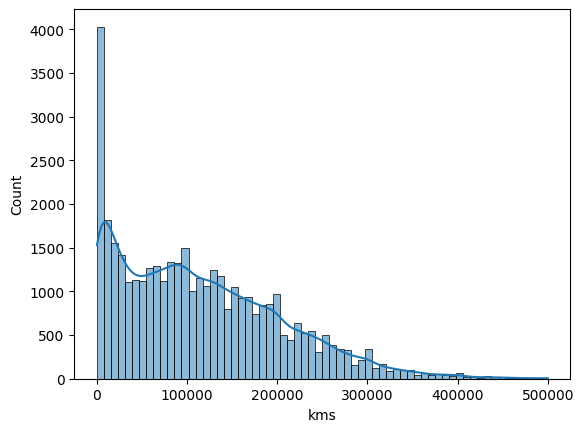

In [46]:
sns.histplot(x = train_set["kms"], data = train_set, kde = True)

#### Power

Power is a **dispersed variable** where 50% of the vehicles' power moves between 110 and 163CV, and last quartile data goes from 163CV to 772CV.

In [47]:
train_set["power"].describe()

count    39177.000000
mean       145.419957
std         61.779437
min         29.000000
25%        110.000000
50%        135.333333
75%        163.000000
max        772.000000
Name: power, dtype: float64

<Axes: xlabel='power', ylabel='Count'>

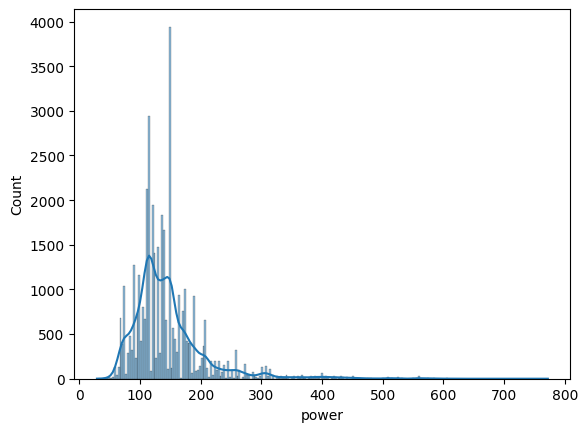

In [48]:
sns.histplot(x = train_set["power"], data = df, kde = True)

#### Doors

**71%** of the vehicles are **5-door vehicles**. Vehicles with 4 doors account for 14%, while 3-door and 2-door vehicles represent 10% and 5% respectively.

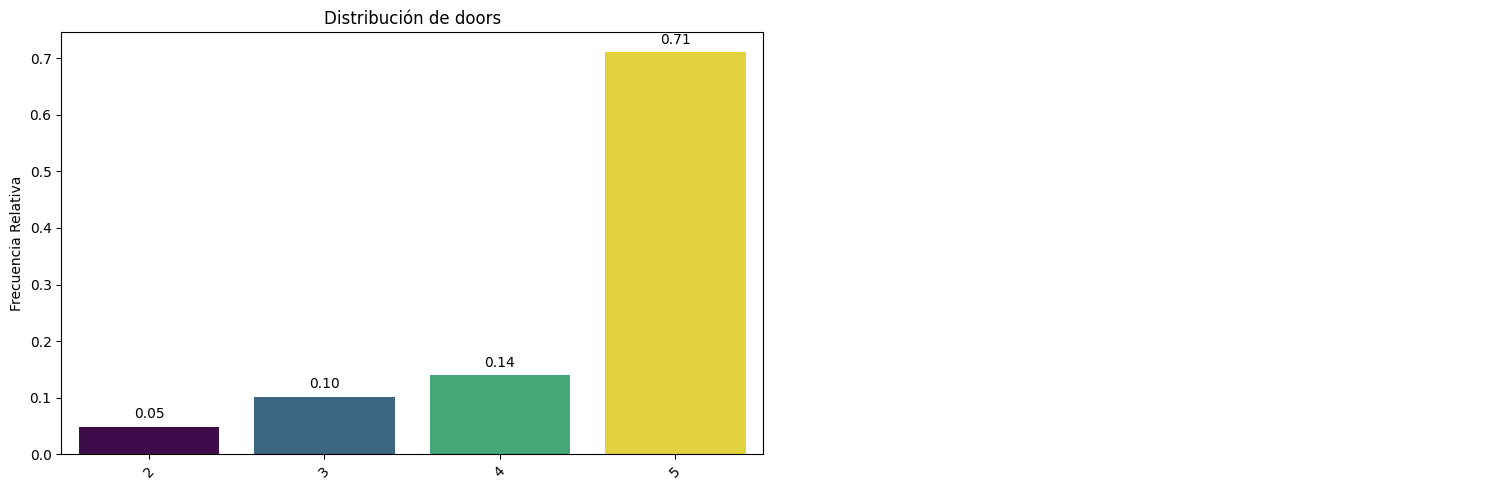

In [49]:
bt.pinta_distribucion_categoricas(train_set, ["doors"], relativa= True, mostrar_valores= True)

#### Shift

**70%** of the vehicles feature a **manual transmission**. However, their average price is much lower.

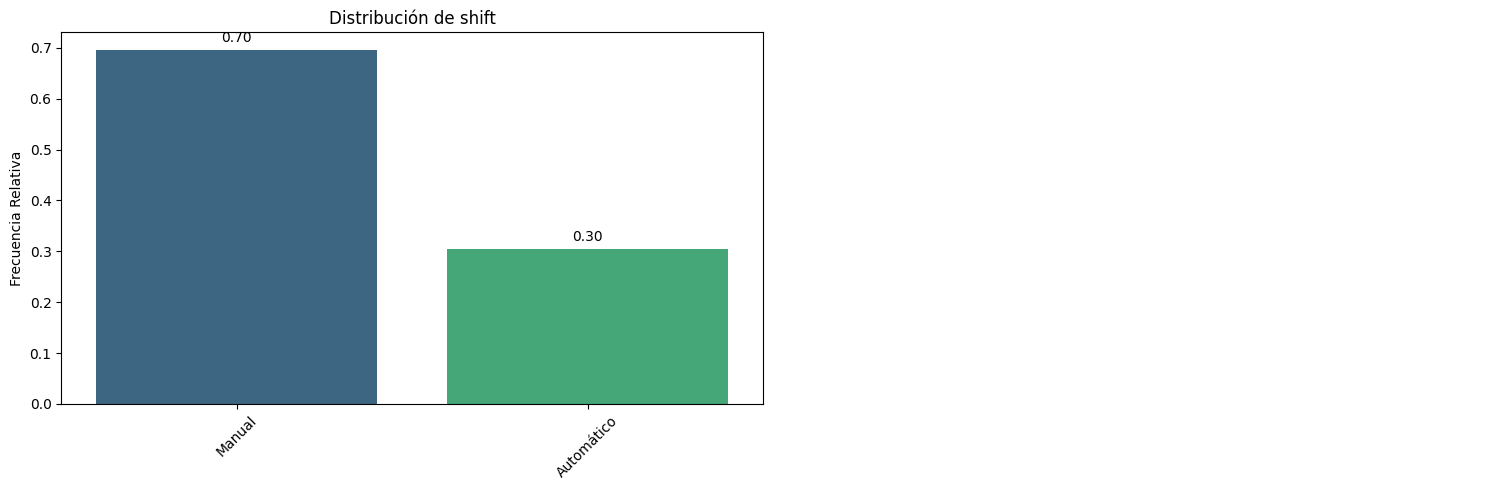

In [50]:
bt.pinta_distribucion_categoricas(train_set, ["shift"], relativa= True, mostrar_valores= True)

In [51]:
for var in train_set["shift"].unique():
    mean_price = round(train_set[train_set["shift"] == var]["price"].mean(),2)
    print(f"Mean price for {var}: {mean_price}€")

Mean price for Automático: 24522.58€
Mean price for Manual: 10422.89€


#### Color

The "color" variable has 3.051 unique values, containing single words or color descriptions. We create a dictionary with a list of colors in Spanish and English to check if they are present in the records. This allowed us to create a new variable with a single color per record.

In [52]:
unique_color=train_set["color"].nunique()
print(f"Unique values: {unique_color}")
card_color=train_set["color"].nunique()/len(train_set["color"])
print(f"Cardinality: {round(card_color,4)*100}%")

Unique values: 3022
Cardinality: 7.71%


In [53]:
# Dictionary
color_dict = {
    "Blanco": "White",
    "Negro": "Black",
    "Gris": "Gray",
    "Rojo": "Red",
    "Azul": "Blue",
    "Verde": "Green",
    "Amarillo": "Yellow",
    "Naranja": "Orange",
    "Rosa": "Pink",
    "Morado": "Purple",
    "Marrón": "Brown",
    "Beige": "Beige",
    #"Turquesa": "Turquoise",
    "Plateado": "Silver",
    "Dorado": "Gold"
}

In [54]:
def assign_main_color(df):

# Input: DataFrame with a "color" column.
# Functionality: assigns a main_color to each car if matching color_dict dictionary,
#                if no match is found, it appends "Other",
#                if the color value was originally null, it appends "Unknown" 
#                creates a new "main_color" column with the assigned new colors, 
#                and then removes the original "color" column. 
# Output: DataFrame with an additional "main_color" column and no "color" column.

    color_resumido=[] 
    for color_coche in df["color"]:
        if pd.notnull(color_coche):  
            color_coche = str(color_coche)
            encontrado = False
            for spa,eng in color_dict.items():
                if (spa or eng) in color_coche:
                    color_resumido.append(spa)
                    encontrado = True
                    break
            if not encontrado:
                color_resumido.append("Other")
        else:
            color_resumido.append("Unknown")
    df["main_color"]=color_resumido

    df.drop("color", axis=1, inplace=True) 


In [55]:
assign_main_color(train_set)

52% of the vehicles for sale are **white** or **gray** in color. Black is the third most common color in the market, followed by blue and red.

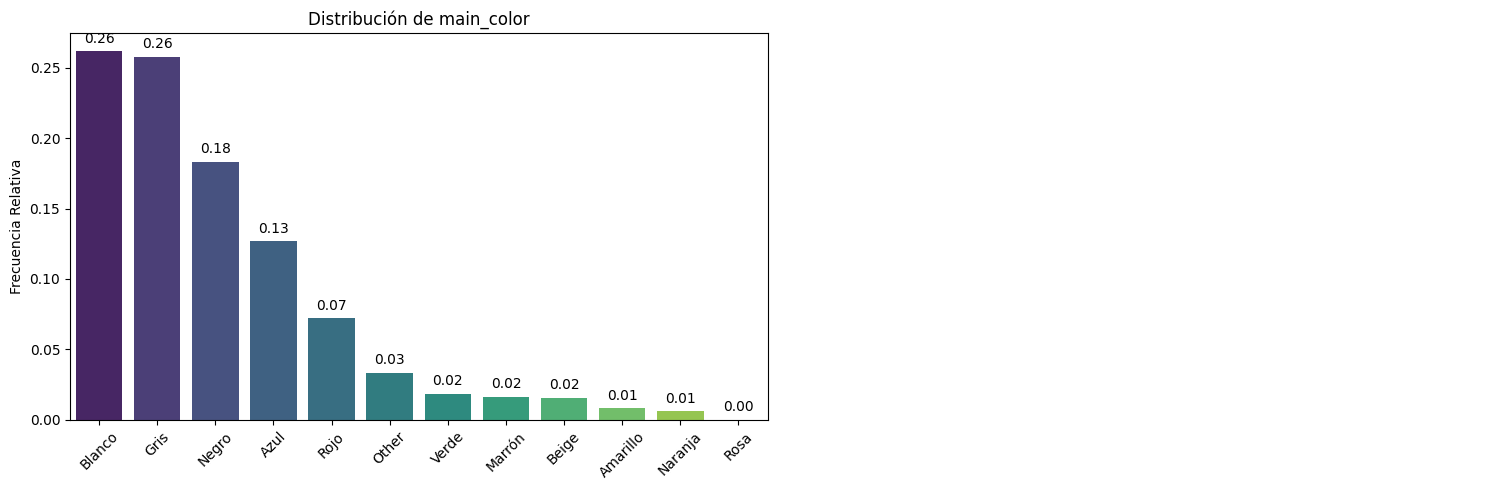

In [56]:
bt.pinta_distribucion_categoricas(train_set, ["main_color"], relativa= True, mostrar_valores= True)

In [57]:
train_set["main_color"].value_counts(normalize=True)

main_color
Blanco      0.261761
Gris        0.257753
Negro       0.183143
Azul        0.126886
Rojo        0.072185
Other       0.033489
Verde       0.018455
Marrón      0.016336
Beige       0.015647
Amarillo    0.008194
Naranja     0.006101
Rosa        0.000051
Name: proportion, dtype: float64

In [58]:
for var in train_set["main_color"].unique():
    mean_price = round(train_set[train_set["main_color"] == var]["price"].mean(),2)
    print(f"Mean price for {var}: {mean_price}€")

Mean price for Azul: 13452.58€
Mean price for Blanco: 16121.22€
Mean price for Negro: 14978.65€
Mean price for Gris: 13953.19€
Mean price for Verde: 8300.67€
Mean price for Rojo: 14398.06€
Mean price for Other: 19171.92€
Mean price for Naranja: 16750.85€
Mean price for Beige: 10327.33€
Mean price for Amarillo: 11149.19€
Mean price for Marrón: 15755.75€
Mean price for Rosa: 12950.0€


#### Photos

There are many ads that do not have pictures of the vehicle, but the ad with most pictures has 54.

<Axes: xlabel='photos', ylabel='Count'>

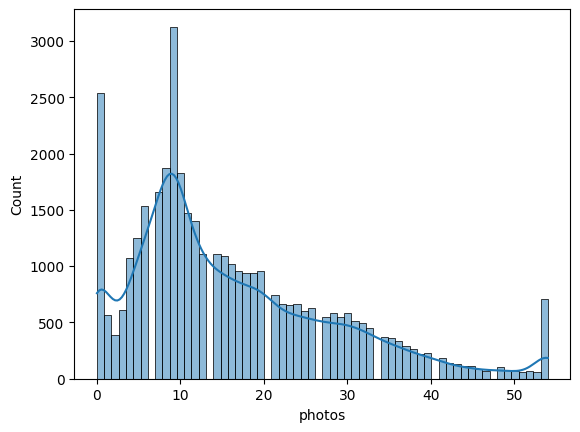

In [59]:
sns.histplot(x = train_set["photos"], data = train_set, kde = True)

In [60]:
train_set["photos"].describe()

count    39177.000000
mean        16.291268
std         12.394533
min          0.000000
25%          8.000000
50%         13.000000
75%         23.000000
max         54.000000
Name: photos, dtype: float64

#### Is professional

**66%** of the vehicles are sold by **professional sellers**, while 34% are sold by individuals. Professional sellers show a **much higher mean price** than particulars.

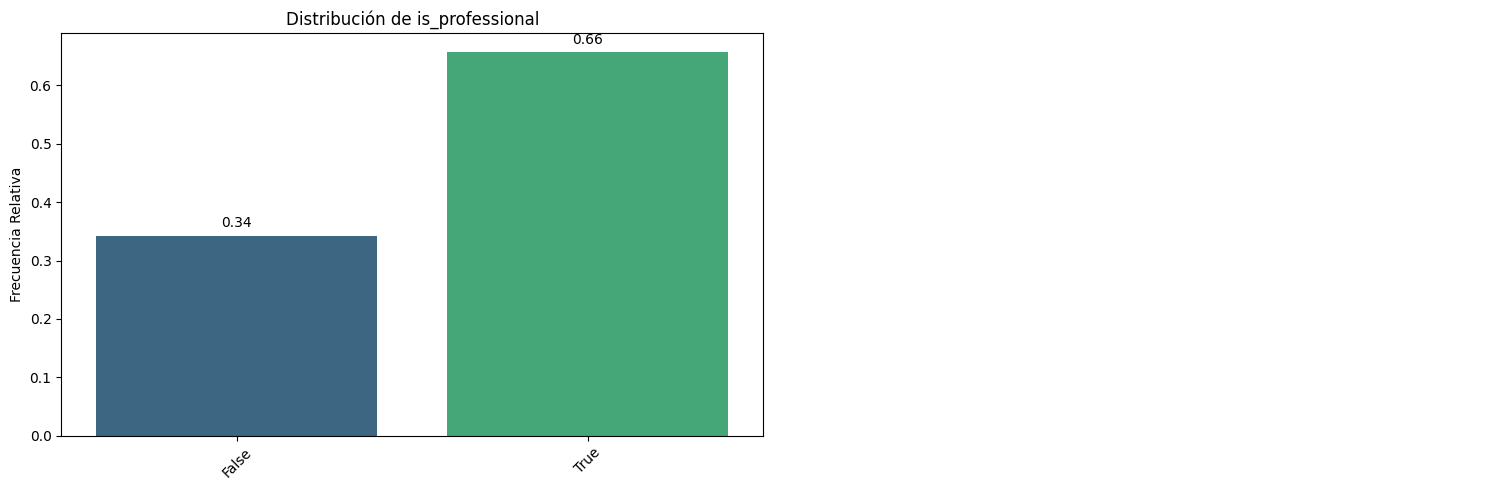

In [61]:
bt.pinta_distribucion_categoricas(train_set, ["is_professional"], relativa= True, mostrar_valores= True)

In [62]:
for var in train_set["is_professional"].unique():
    mean_price = round(train_set[train_set["is_professional"] == var]["price"].mean(),2)
    print(f"Mean price for {var}: {mean_price}€")

Mean price for True: 18456.45€
Mean price for False: 7539.32€


#### Province

From the "province" (with 52 unique values and a cardinality of 0.13%), we create the comunity variable to group data by autonomous community.

In [63]:
unique_province=train_set["province"].nunique()
print(f"Unique values: {unique_province}")
card_province=train_set["province"].nunique()/len(train_set["province"])
print(f"Cardinality: {round(card_province,4)*100}%")
top_province=train_set["province"].value_counts(normalize=True).nlargest(30).sum()
print(f"Top 30 provinces: {round(top_province,4)*100}%")

Unique values: 52
Cardinality: 0.13%
Top 30 provinces: 89.49000000000001%


In [64]:
# Dictionary
provinces_dict = {
    'Álava': 'País Vasco',
    'Albacete': 'Castilla La Mancha',
    'Alicante': 'Comunidad Valenciana',
    'Almería': 'Andalucía',
    'Asturias': 'Asturias',
    'Ávila': 'Castilla y León',
    'Badajoz': 'Extremadura',
    'Barcelona': 'Cataluña',
    'Burgos': 'Castilla y León',
    'Cáceres': 'Extremadura',
    'Cádiz': 'Andalucía',
    'Cantabria': 'Cantabria',
    'Castellón': 'Comunidad Valenciana',
    'Ceuta': 'Ceuta',
    'Ciudad Real': 'Castilla La Mancha',
    'Córdoba': 'Andalucía',
    'Cuenca': 'Castilla La Mancha',
    'Girona': 'Cataluña',
    'Granada': 'Andalucía',
    'Guadalajara': 'Castilla La Mancha',
    'Guipúzcoa': 'País Vasco',
    'Huelva': 'Andalucía',
    'Huesca': 'Aragón',
    'Baleares': 'Islas Baleares',
    'Jaén': 'Andalucía',
    'A Coruña': 'Galicia',
    'La Rioja': 'La Rioja',
    'Las Palmas': 'Canarias',
    'León': 'Castilla y León',
    'Lleida': 'Cataluña',
    'Lugo': 'Galicia',
    'Madrid': 'Comunidad de Madrid',
    'Málaga': 'Andalucía',
    'Melilla': 'Melilla',
    'Murcia': 'Región de Murcia',
    'Navarra': 'Navarra',
    'Orense': 'Galicia',
    'Palencia': 'Castilla y León',
    'Pontevedra': 'Galicia',
    'Salamanca': 'Castilla y León',
    'Tenerife': 'Canarias',
    'Segovia': 'Castilla y León',
    'Sevilla': 'Andalucía',
    'Soria': 'Castilla y León',
    'Tarragona': 'Cataluña',
    'Teruel': 'Aragón',
    'Toledo': 'Castilla La Mancha',
    'Valencia': 'Comunidad Valenciana',
    'Valladolid': 'Castilla y León',
    'Vizcaya': 'País Vasco',
    'Zamora': 'Castilla y León',
    'Zaragoza': 'Aragón'
}

In [65]:
def assign_community(df):

# Input: DataFrame with a "province" column.
# Functionality: assigns a community to each car if matching provinces_dict dictionary,
#                if no match is found, it appends "Unknown",
#                creates a new "community" column with the assigned new colors, 
#                and then removes the original "province" column. 
# Output: DataFrame with an additional "community" column and no "province" column.

    provinces= df["province"]
    comunidad=[]
    for prov in provinces:
        found = False
        for key, value in provinces_dict.items():
            if prov == key:
                comunidad.append(value)
                found = True
                break
        if not found:
            comunidad.append("Desconocida")     
    df["community"] = comunidad
    
    df.drop("province", axis=1, inplace=True)


In [66]:
assign_community(train_set)

**19,4%** of the cars for sale are located in the **Community of Madrid**. **Andalusia and Catalonia** closely follow with 16,64% and 15,7%, respectively. Except Community of Valencia, the rest of the autonomous communities each encompass around or less than 5% of the data individually.

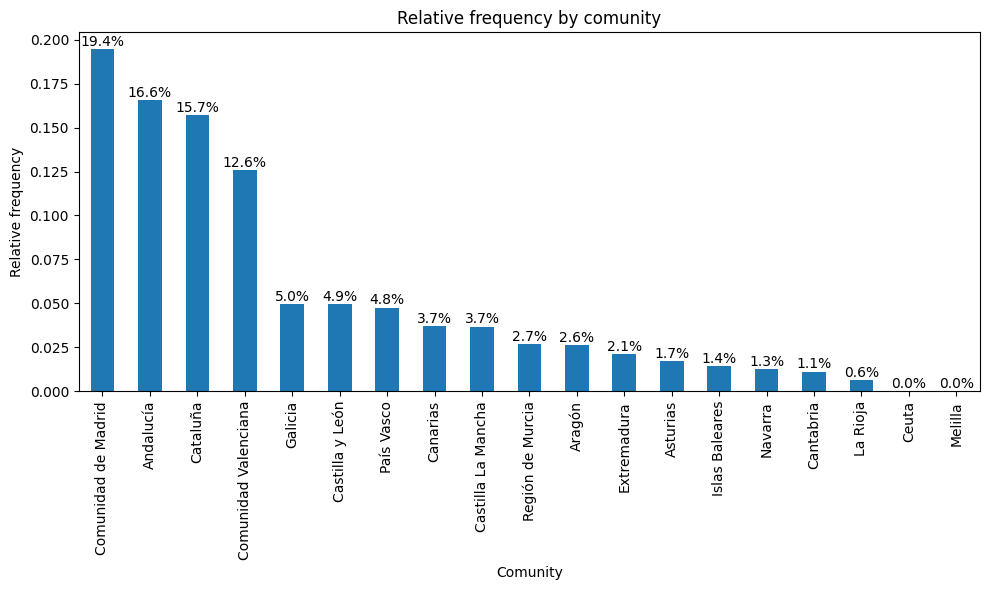

In [67]:
# Create the figure
community_counts = train_set["community"].value_counts(normalize=True)
plt.figure(figsize=(10, 6))
community_counts.plot(kind='bar')

# Aggregate the values for each brand
for i, value in enumerate(community_counts):
    plt.text(i, value + 0.0001, str(round(value*100, 1)) + "%", ha='center', va='bottom')

# Tags and tittles
plt.xlabel('Comunity')
plt.ylabel('Relative frequency')
plt.title('Relative frequency by comunity')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the figure
plt.show()

In [68]:
for var in train_set["community"].unique():
    mean_price = round(train_set[train_set["community"] == var]["price"].mean(),2)
    print(f"Mean price for {var}: {mean_price}€")

Mean price for Andalucía: 13648.5€
Mean price for País Vasco: 16164.69€
Mean price for Canarias: 11771.02€
Mean price for Cataluña: 15573.52€
Mean price for Comunidad Valenciana: 15095.69€
Mean price for Comunidad de Madrid: 15947.86€
Mean price for Extremadura: 11381.17€
Mean price for Castilla La Mancha: 13110.52€
Mean price for Aragón: 14264.16€
Mean price for Castilla y León: 15329.67€
Mean price for Asturias: 14910.07€
Mean price for Galicia: 14437.39€
Mean price for Navarra: 14409.57€
Mean price for Cantabria: 14690.03€
Mean price for Región de Murcia: 13031.1€
Mean price for Islas Baleares: 12327.36€
Mean price for La Rioja: 15010.18€
Mean price for Ceuta: 10504.17€
Mean price for Melilla: 8481.82€


### Multivariate analysis

#### Numeric variables

**Power** is the numeric variable most correlated with the target, at 0,7. **Kms** is also correlated but inversely (-0,41). **Photos** (0,3) and **is_professional** (0,34) are also slightly related to the target and are correlated with each other (0.56). Doors is not correlated with any other numeric variable.

In [69]:
features_num=["kms","power","doors","photos","is_professional"]

In [70]:
corr = train_set.corr(numeric_only= True)
np.abs(corr[target]).sort_values(ascending = False)

price              1.000000
power              0.586027
kms                0.538167
is_professional    0.404096
photos             0.349289
doors              0.046752
Name: price, dtype: float64

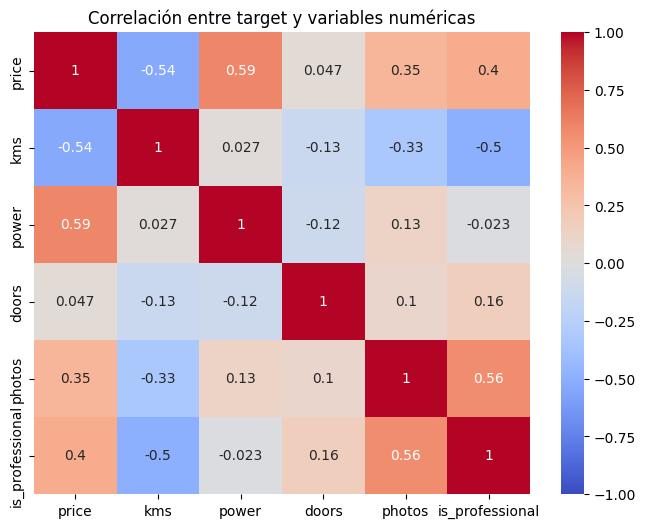

In [71]:
# Correlation matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación entre target y variables numéricas")
plt.show()

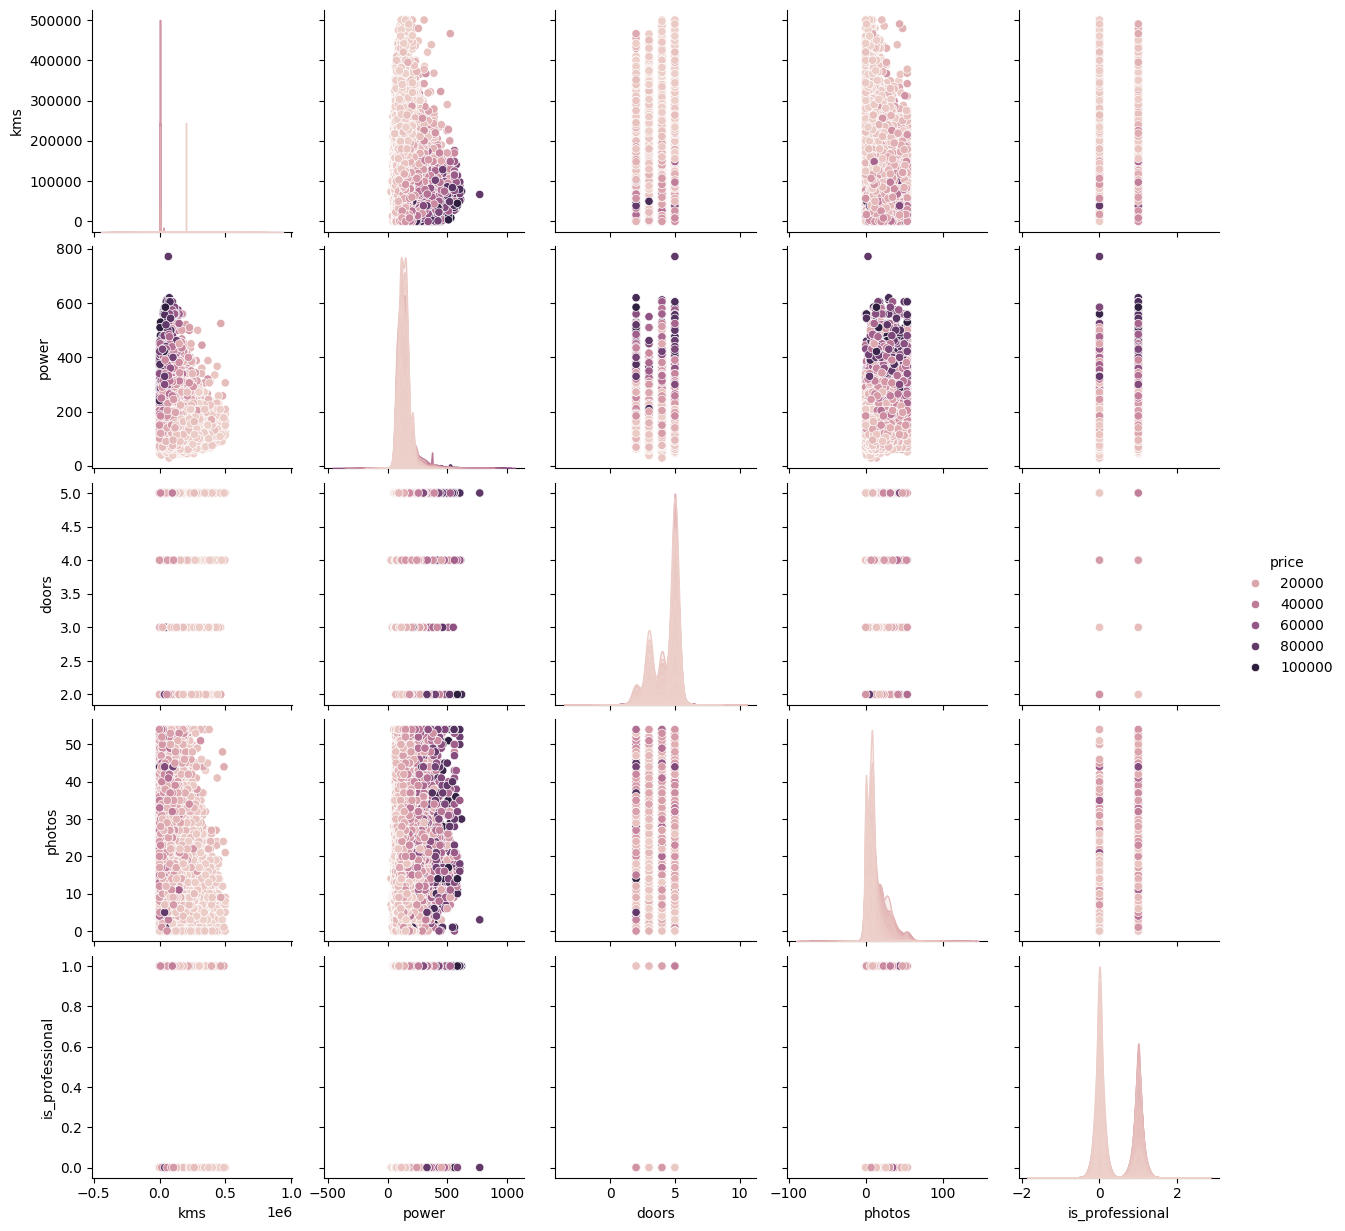

In [72]:
sns.pairplot(train_set[features_num + [target]], hue = target)

In [73]:
selected_features_num=["power","kms"]
postselected_features_num=["is_professional","photos"]
all_selected_features_num= selected_features_num+postselected_features_num

#### Categorical variables

The seven categorical variables seem to have values for which the distribution with respect to the target is different. Different behaviors for the price variable indicate influence on it. Therefore, we keep all these variables to create the model.

* Brand: Mercedes, BMW, Land-Rover and high cost brands have vehicles at a higher price than the rest of the brands.
* Segment: A segment vehicles have prices in a much narrow range.
* Age: classic cars are much cheaper than old and almost new cars.
* Fuel: gasolina and diesel cars can be found at a cheaper price than other fuels' cars.
* Shift:the most expensive cars have atometic shift.
* Color_resumido: orange and unknown color' cars are cheaper than others. However, there are a few of them.
* Comunidad: Ceuta, Melilla and unknown comunity' cars are cheaper.

In [74]:
features_cat=["brand","segment","age","fuel","shift","main_color","community"]

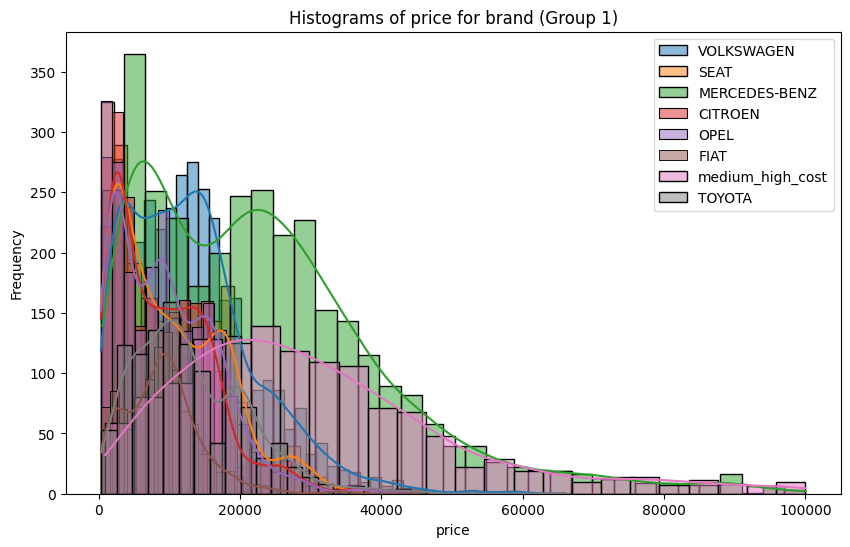

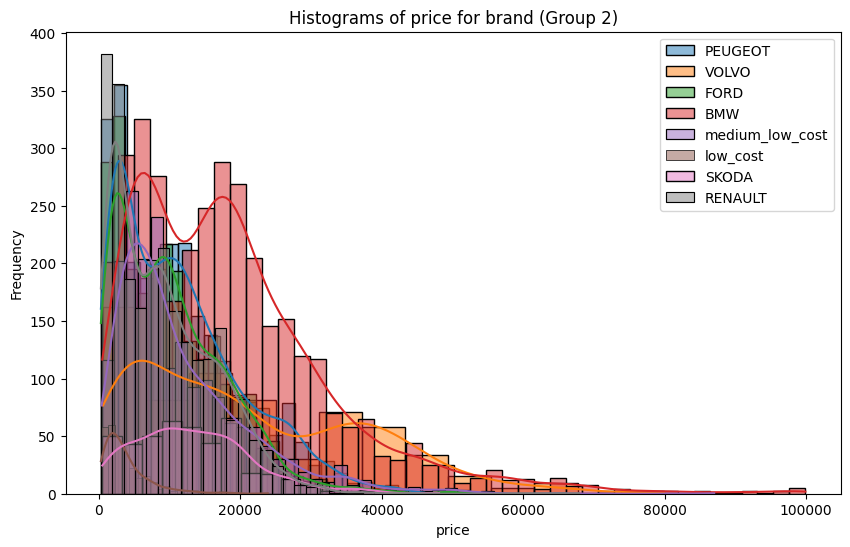

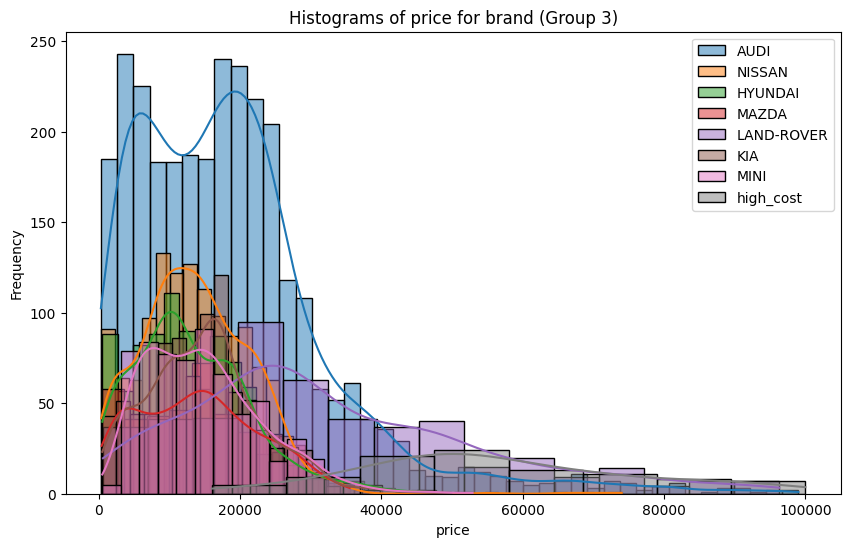

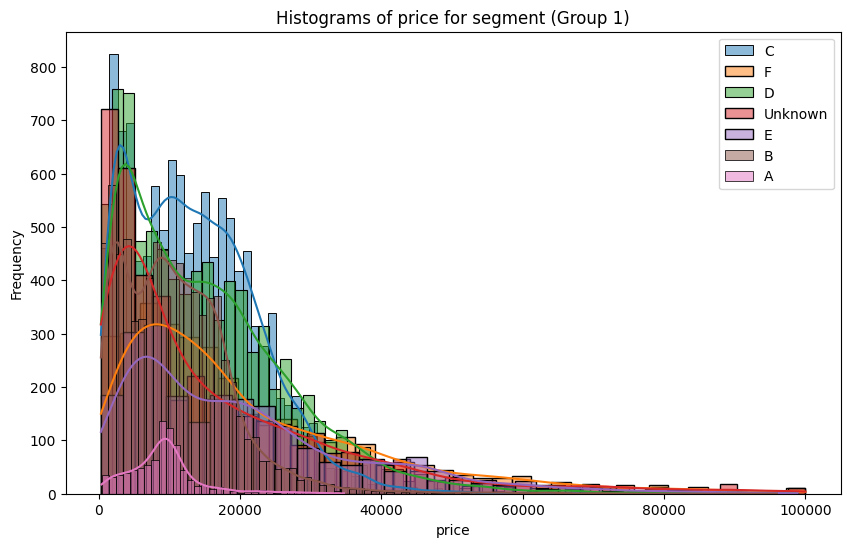

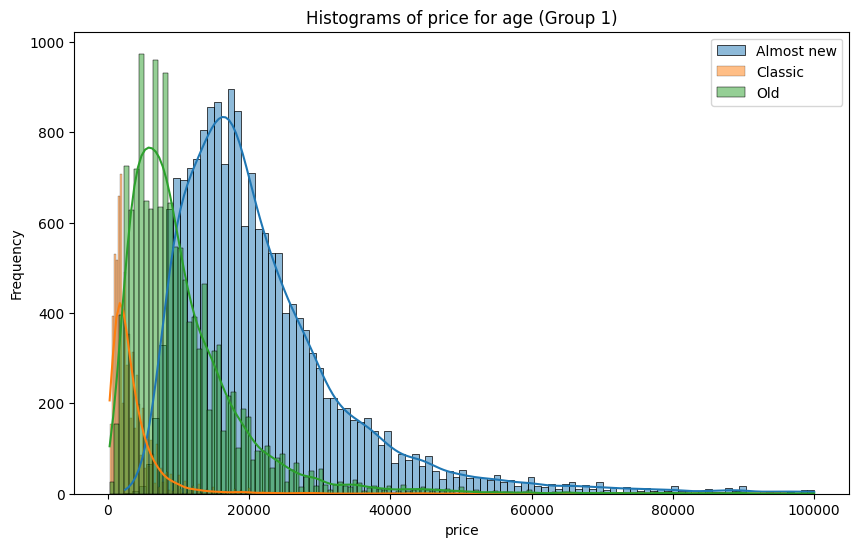

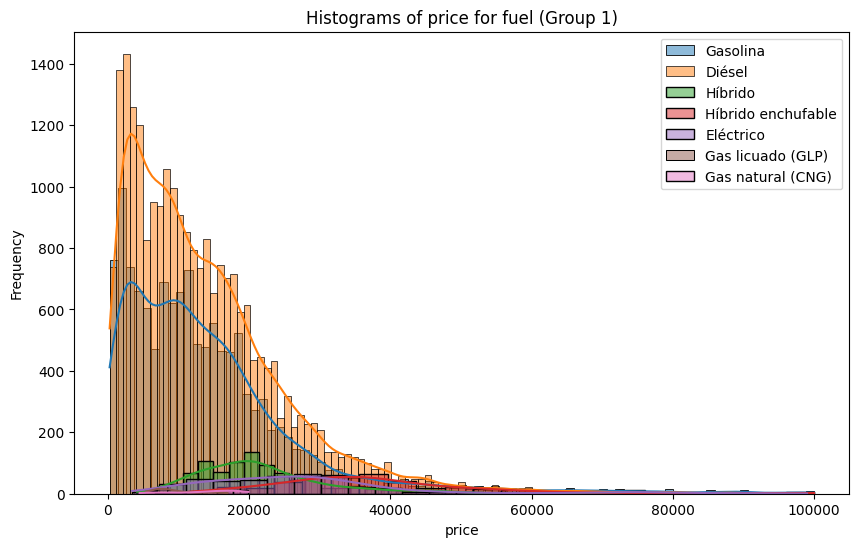

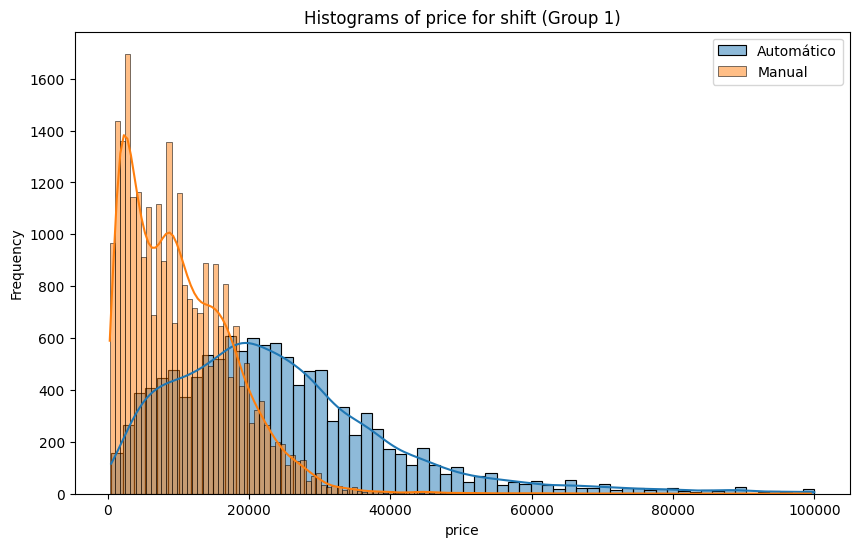

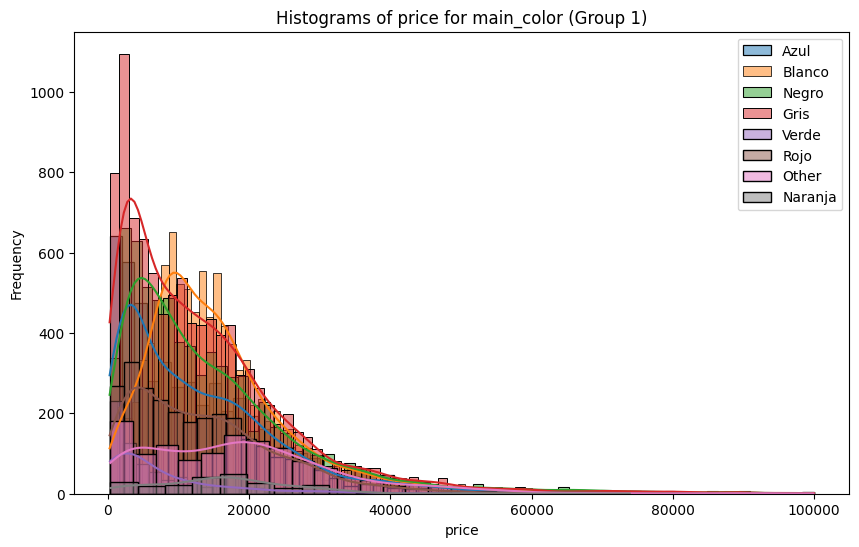

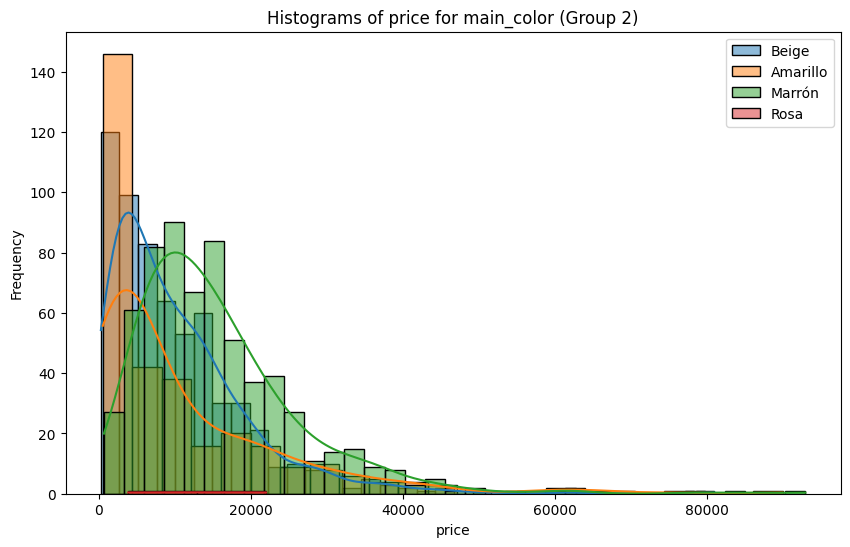

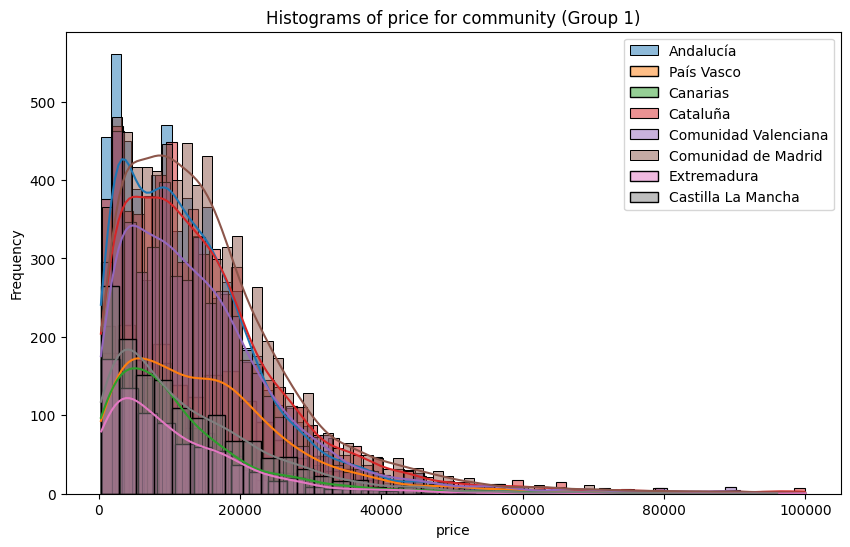

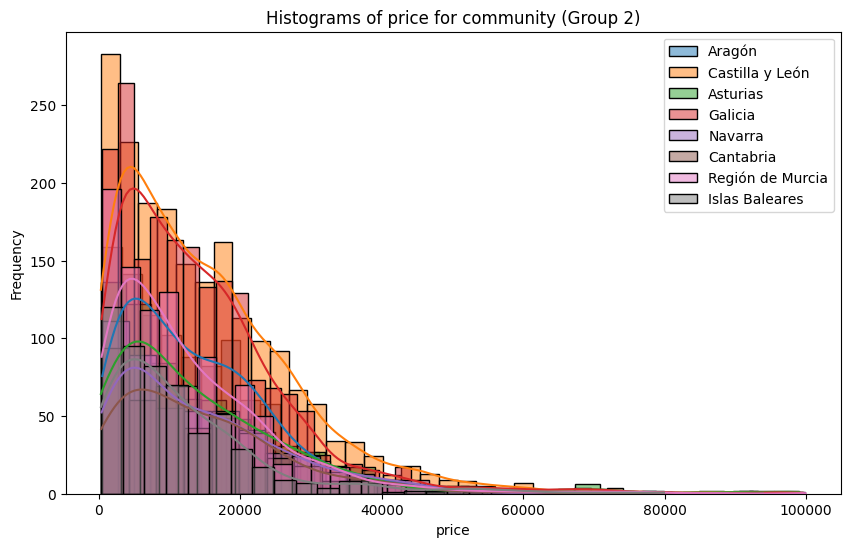

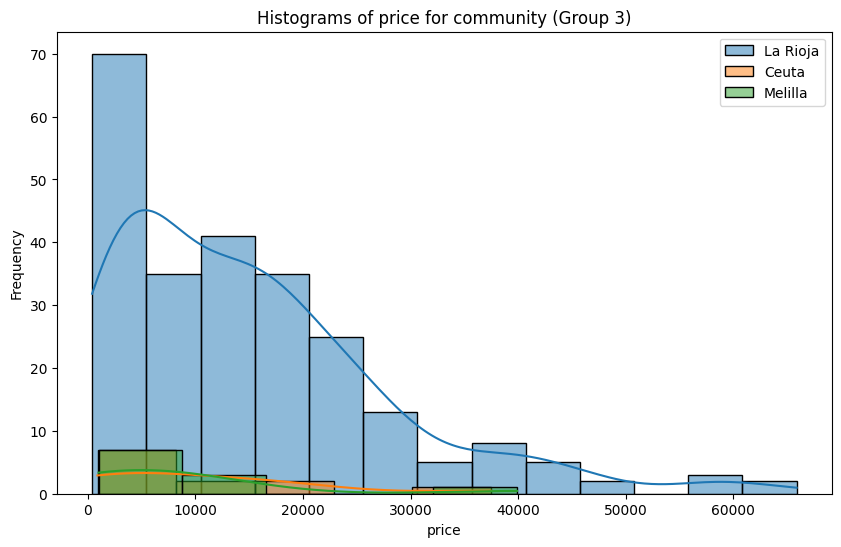

In [75]:
for col in features_cat:
    bt.plot_grouped_histograms(train_set, cat_col= col, num_col= target, group_size=8)

In [76]:
selected_features_cat=["brand","segment","age","shift","fuel"]
postselected_features_cat=["main_color","community"]
all_selected_features_cat= selected_features_cat+postselected_features_cat

## Features conversion

In [77]:
selected_features=selected_features_num+selected_features_cat
selected_features

['power', 'kms', 'brand', 'segment', 'age', 'shift', 'fuel']

In [78]:
postselected_features=postselected_features_num+postselected_features_cat
postselected_features

['is_professional', 'photos', 'main_color', 'community']

#### Numéricas

Since the numerical variables have very disparate ranges, they need to be scaled. We choose **standardization** (mean close to 0 and standard deviation close to 1) since there are many outliers.

Before that, we need to **normalize** the power, kms and doors variables to prevent values from concentrating in very small ranges.

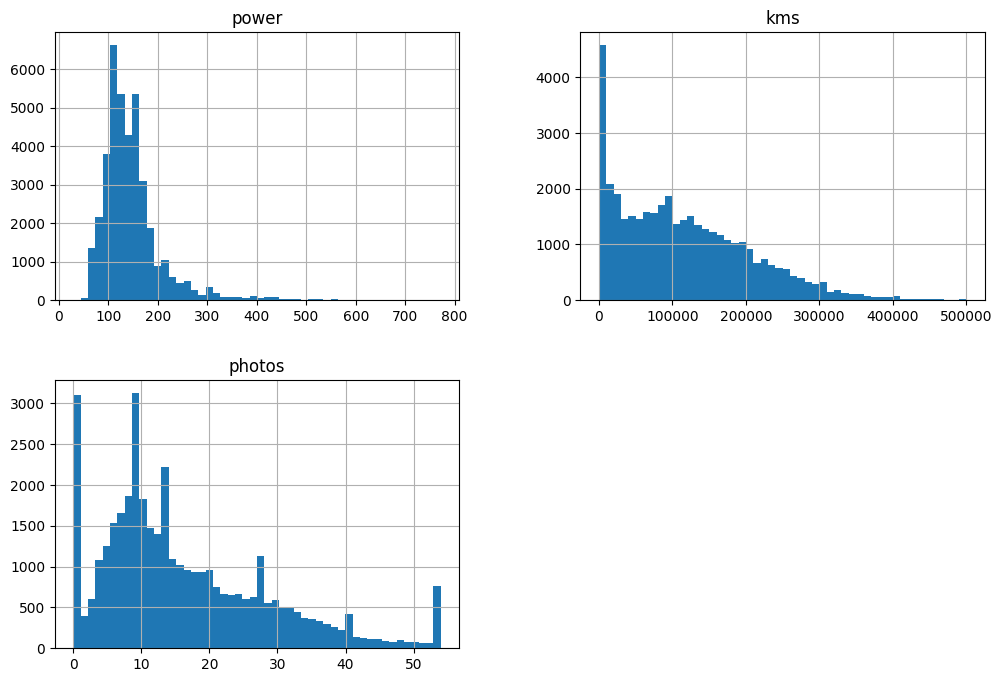

In [79]:
# Review.
train_set[all_selected_features_num].hist(bins=50, figsize=(12, 8)) 
plt.show()

In [80]:
def convert_num(df):

# Input: dataframe with numerical variables called "power", "kms", ""doors and photos columns.
#Functniolatily: It applies the natural logarithm transformation to normalize the distribution. (+ 1) is to avoid errors when the column contains zero,
#                initializes a StandardScaler object std_scaler and creates new columns in the original df with the scaled values.
#                finally, it drops the original columns that were transformed to retain only the scaled features.
# Output: dataframe with the same numerical variables bus scaled.

    df["log_power"] = np.log(df["power"] + 1)
    df["log_kms"] = np.log(df["kms"] + 1)
    df["log_doors"] = np.log(df["doors"] + 1)

    std_scaler = StandardScaler()

    log_power_df = df[["log_power"]]
    log_kms_df = df[["log_kms"]]
    log_doors_df = df[["log_doors"]]
    photos_df = df[["photos"]]

    df["power_scaled"] = std_scaler.fit_transform(log_power_df)
    df["kms_scaled"] = std_scaler.fit_transform(log_kms_df)
    df["photos_scaled"] = std_scaler.fit_transform(photos_df)
    df["doors_scaled"] = std_scaler.fit_transform(log_doors_df)

    df.drop(columns=["power","kms","photos","doors","log_power","log_kms","log_doors"], axis=1, inplace=True)

In [81]:
convert_num(train_set)

#### Categóricas

Transformamos las variables categóricas a numéricas a través de un One Hot Encoder.

In [82]:
columns_to_encode = ["brand", "segment", "age", "fuel", "main_color", "community"]
# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=int)
# Fit and transform the selected columns
encoded_columns = encoder.fit_transform(train_set[columns_to_encode])
# Create a DataFrame from the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
# Reset the index before concatenate dataframes
train_set.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
# Concatenate the encoded DataFrame with the original df
train_set = pd.concat([train_set, encoded_df], axis=1)
# Drop the original columns from the df
train_set.drop(columns=columns_to_encode, axis=1, inplace=True)


# Transform boolean variables.
shift_mapping = {"Manual": 0, "Automático": 1}
train_set["shift"] = train_set["shift"].map(shift_mapping)
train_set['is_professional'] = train_set['is_professional'].astype(float)


c:\Users\albab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Testing set conversion

The testing set need to have the same convertions before being used in the model. Otherwise, the model would't be able to predict.

In [83]:
assign_brand(test_set)
assign_segment(test_set)
assign_age(test_set)
test_set=suspicious_kms(test_set)
assign_main_color(test_set)
assign_community(test_set)
convert_num(test_set)

In [84]:
# The categorical conversion is not working in a function --> we repeat the process.

columns_to_encode = ["brand", "segment", "age", "fuel", "main_color", "community"]
# Fit and transform the selected columns
encoded_columns = encoder.fit_transform(test_set[columns_to_encode])
# Create a DataFrame from the encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(columns_to_encode))
# Reset the index before concatenate dataframes
test_set.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)
# Concatenate the encoded DataFrame with the original df
test_set = pd.concat([test_set, encoded_df], axis=1)
# Drop the original columns from the df
test_set.drop(columns=columns_to_encode, axis=1, inplace=True)

test_set["shift"] = test_set["shift"].map(shift_mapping)
test_set['is_professional'] = test_set['is_professional'].astype(float)

c:\Users\albab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Modelling

### Initialization

The four model chosen are:
* Linear Regression
* Random Forest Regressor
* XGBoost Regressor (Extreme Gradient Boosting)
* LightGBM Regressor (Light Gradient Boosting Machine)

Before that, is neccesary to separate target and features in each set.

In [85]:
y_train = train_set[target]
y_test = test_set[target]

X_train = train_set.drop(columns=[target])
X_test = test_set.drop(columns=[target])

In [86]:
lin_reg = LinearRegression()
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42) # El número de niveles para "probar" lo pongo más alto que en clasificación porque el rango de valores de la target es mucho mayor
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)
lgb_reg = LGBMRegressor(max_depth = 10, random_state = 42, verbose = -100)
#svr = SVR()


models = {
    "Linear Regression": lin_reg, 
    "Random Forest": rf_reg,
    "Lightgbm": lgb_reg,
    "XGBoost": xgb_reg,
    #"SVM Regressor": svr

}

### Comparison

**XGBoost** is the model that shows the best results in cross-validation.
* MAE:2.267,99€
* RMSE: 3.852,29€
* MAPE: 28,36%

It is closely followed by LightGBM and Random Forest. Linear Regressor is the model with the worst performance.

In [87]:
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

for tipo, modelo in models.items():
    print(f"{tipo}: ", end=" ")
    modelo.fit(X_train, y_train)
    
    mae_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_error))
    mse_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring=make_scorer(mean_squared_error))
    rmse_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring=make_scorer(root_mean_squared_error))
    mape_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring=make_scorer(mean_absolute_percentage_error))
    
    print(f"mae: {mae_scores.mean()}")
    print(f"rmse: {np.sqrt(mse_scores.mean())}")
    print(f"mape: {mape_scores.mean()}")
    print("******")

Linear Regression:  

mae: 4365.826279857552
rmse: 6467.416191181133
mape: 70.13862663854691
******
Random Forest:  mae: 2703.192571323256
rmse: 4238.322129018407
mape: 33.730049774581246
******
Lightgbm:  mae: 2426.4719175897253
rmse: 3842.8119134764815
mape: 28.347824465467728
******
XGBoost:  mae: 2271.710003590989
rmse: 3811.8843529329856
mape: 26.16519820700255
******


### Hyperparameter tuning

Grid Search is aimed to fine-tune the model hyperparameters to opimize its performance. Hyperparameters are parameters that are set before the learning process begins, and Grid Search is a method used to systematically explore a range of hyperparameter values to find the best performing combination.

In [88]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 1.0}
Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


In [89]:
best_params

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 5,
 'subsample': 1.0}

In [90]:
best_estimator

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Prediction with the testing set

After tuning, we train again the model with the training set and finally **predict the prices in the testing set**. Results of the prediction are similar than in the training set.

In [91]:
xgb_best = LGBMRegressor(**best_params)

# Entrenar el modelo en todo el conjunto de entrenamiento
xgb_best.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 39177, number of used features: 75
[LightGBM] [Info] Start training from score 14714.301657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

LGBMRegressor(colsample_bytree=0.8, gamma=0, learning_rate=0.3, max_depth=7,
              min_child_weight=5)

In [92]:
y_pred = xgb_best.predict(X_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [93]:
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAE: 2395.901660438828
RMSE: 3850.4750517831408
MAPE: 27.8644008399879


The prediction is quite accurate.

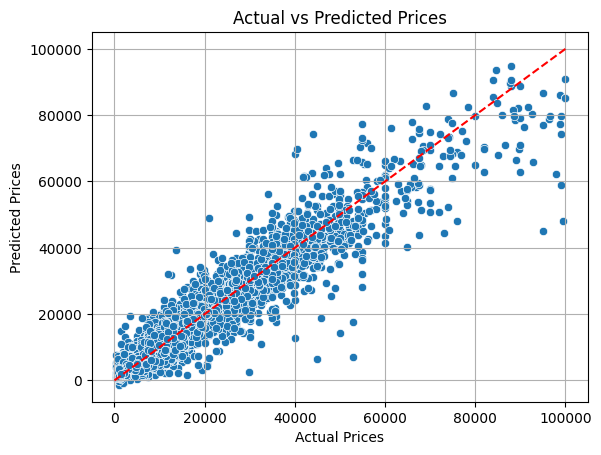

In [94]:
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.show()

## Saving the model

In [95]:
with open('xgb_best.pkl', 'wb') as file:
    pickle.dump(xgb_best, file)